<a href="https://colab.research.google.com/github/namespaiva/pred-analysis/blob/main/simulado1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulado

## 1

In [1]:
!pip install ucimlrepo

In [2]:
import ucimlrepo
import pandas as pd
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

dados = ucimlrepo.fetch_ucirepo(id=53)

X = dados.data.features
y= dados.data.targets

filtro = y['class'] != 'Iris-virginica'
y = y[filtro]
X = X[filtro]

y = y.replace('Iris-setosa', 0)
y = y.replace('Iris-versicolor', 1)

X_f = X.copy()
y_f = y.copy()

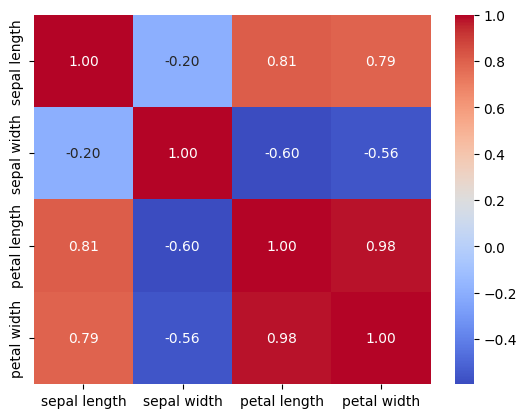

In [3]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X_f, y_f, test_size=0.2)

sns.heatmap(X_f.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

In [4]:
cols = list(X.columns)

coords = {'features': cols}

In [5]:
y_train.values.flatten()

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0])

In [6]:
import pytensor.tensor as tt

with pm.Model(coords = coords) as modeloIris:
  betas = pm.Normal('betas', 0, 1, dims='features')
  alpha = pm.Normal('alpha')

  X = [
    pm.MutableData("X_"+column,X_train[column].values)
    for column in X_train.columns if np.issubdtype(X_f[column].dtype, np.number)
  ]

  y = pm.MutableData("y",y_train.values.flatten())

  mu = alpha + tt.dot(betas, X)
  likelihood = pm.Bernoulli('likelihood',pm.math.invlogit(mu),observed=y)

with modeloIris:
  #approx = pm.fit(2000)
  trace = pm.sample(20000)

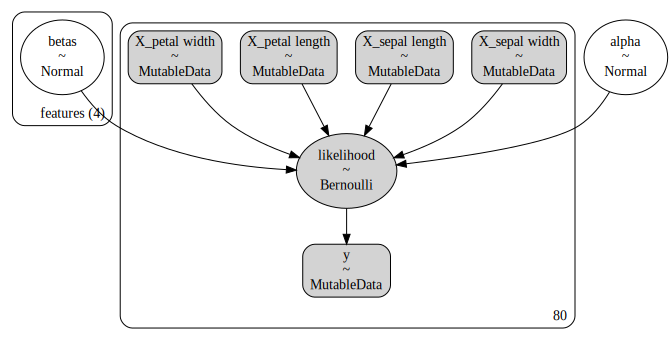

In [7]:
pm.model_to_graphviz(modeloIris)

In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.253,0.970,-2.068,1.591,0.006,0.005,23326.0,22537.0,1.0
betas[sepal length],-0.431,0.593,-1.549,0.665,0.005,0.004,12400.0,16453.0,1.0
betas[sepal width],-1.480,0.760,-2.926,-0.063,0.006,0.005,13761.0,18407.0,1.0
betas[petal length],2.337,0.629,1.162,3.521,0.005,0.003,18017.0,22359.0,1.0
betas[petal width],1.055,0.934,-0.719,2.782,0.006,0.004,24159.0,25146.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

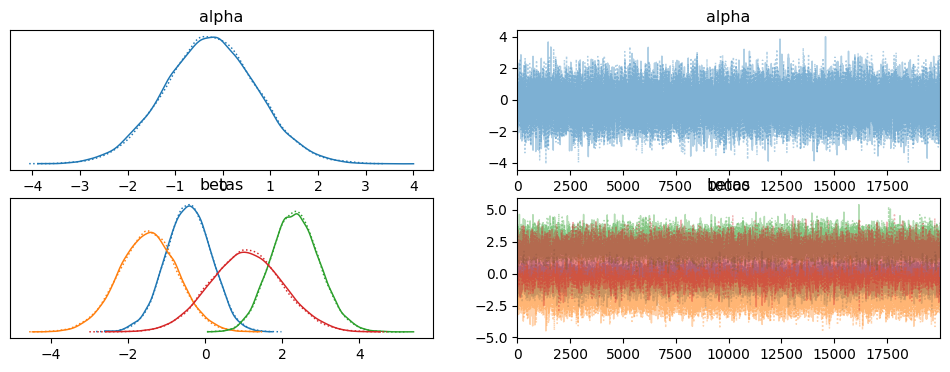

In [9]:
az.plot_trace(trace)

In [10]:
vars = {"X_"+column : X_test[column].values
    for column in X_test.columns if np.issubdtype(X_test[column].dtype, np.number)}
vars["y"] = y_test.values.flatten()

with modeloIris:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

In [11]:
mean_likelihood = trace_post.posterior_predictive.likelihood.mean(dim=['chain', 'draw'])
binary_predictions = (mean_likelihood > 0.5).astype(int).values[:len(y_test.values.flatten())]

abs_diff = np.abs(y_test.values.flatten() - binary_predictions)
accuracy = 1 - np.mean(abs_diff)

df = pd.DataFrame({'y_test': y_test.values.flatten(), 'binary_predictions': binary_predictions})
df['abs_diff'] = abs_diff
df['accuracy'] = accuracy

errors = df["abs_diff"].sum()
acc = (len(df)-errors)/len(df)
print(f"Acuracia: {acc:.4f}")
print(f"Erros: {errors}")

Acuracia: 1.0000
Erros: 0


## 2

In [12]:
!pip install ucimlrepo

In [13]:
import ucimlrepo
import pandas as pd
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as tt
dados = ucimlrepo.fetch_ucirepo(id=162)

df = pd.DataFrame(dados.data.features)
df['areas'] = dados.data.targets

months = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
days = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':0}

df['month'] = df['month'].map(months)
df['day'] = df['day'].map(days)

df.sample(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,areas
336,7,4,9,1,91.6,108.4,764.0,6.2,19.3,44,2.2,0.0,0.00
497,3,4,8,2,96.1,181.1,671.2,14.3,32.3,27,2.2,0.0,14.68
399,9,5,6,3,93.3,49.5,297.7,14.0,28.0,34,4.5,0.0,0.00
371,3,4,7,3,91.9,133.6,520.5,8.0,14.2,58,4.0,0.0,0.00
130,4,6,2,6,68.2,21.5,87.2,0.8,15.4,40,2.7,0.0,0.00
78,1,2,8,5,90.1,108.0,529.8,12.5,14.7,66,2.7,0.0,0.00
383,9,6,8,4,91.6,248.4,753.8,6.3,20.5,58,2.7,0.0,42.87
437,8,6,8,6,89.4,253.6,768.4,9.7,14.2,73,2.7,0.0,0.00
322,6,5,9,4,92.8,119.0,783.5,7.5,16.8,28,4.0,0.0,1.01
84,1,2,8,4,91.7,114.3,661.3,6.3,20.2,45,3.6,0.0,0.00


In [14]:
features = df[['X', 'Y', 'temp']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

df['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
from sklearn.model_selection import train_test_split as tts

coords = {
    'features': ['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'cluster']
}

X = pd.DataFrame()
y = pd.DataFrame()

X = df.drop(['areas','X','Y'], axis=1)
y = df['areas']

scaler = StandardScaler()
X_f = scaler.fit_transform(X)
X_f = pd.DataFrame(X_f, columns=X.columns)

X_train, X_test, y_train, y_test = tts(X_f, y, test_size=0.2)

In [16]:
with pm.Model(coords=coords) as model_ridge:
  alpha = pm.Normal('alpha', 0, 1)
  betas = pm.Normal('betas', 0, 1, dims='features')
  epsilon = pm.HalfNormal('epsilon', 1)

  mu = alpha + tt.dot(X_f, betas)

  likelihood = pm.Normal('Y_obs', mu, epsilon, observed=y)
  trace_ridge = pm.sample()

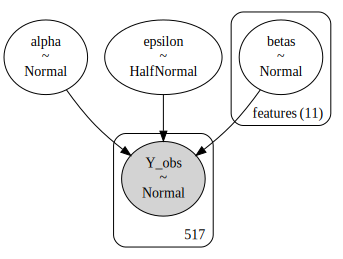

In [17]:
pm.model_to_graphviz(model_ridge)

In [18]:
pm.summary(trace_ridge)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.843,0.850,2.308,5.495,0.016,0.012,2754.0,1463.0,1.0
betas[month],0.656,0.873,-0.972,2.356,0.015,0.017,3276.0,1381.0,1.0
betas[day],0.904,0.834,-0.564,2.580,0.016,0.013,2712.0,1598.0,1.0
betas[FFMC],0.306,0.846,-1.379,1.848,0.016,0.018,2850.0,1580.0,1.0
betas[DMC],1.066,0.883,-0.559,2.757,0.017,0.015,2829.0,1369.0,1.0
betas[DC],0.363,0.896,-1.298,1.977,0.017,0.019,2712.0,1658.0,1.0
betas[ISI],-0.278,0.872,-1.790,1.502,0.016,0.018,2928.0,1526.0,1.0
betas[temp],1.434,0.859,-0.015,3.066,0.016,0.013,2978.0,1669.0,1.0
betas[RH],-1.156,0.856,-2.758,0.390,0.016,0.013,2858.0,1537.0,1.0
betas[wind],0.445,0.860,-1.077,2.090,0.014,0.017,3523.0,1563.0,1.0


array([<Axes: xlabel='Y_obs'>], dtype=object)

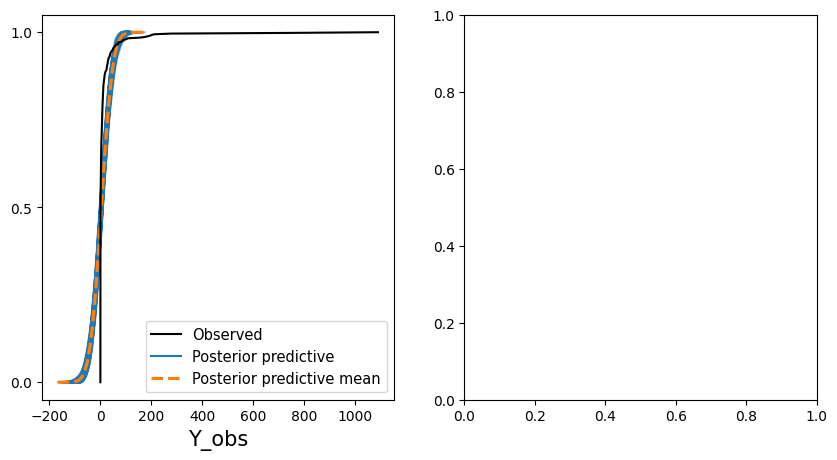

In [19]:
with model_ridge:
  trace_pos_ridge = pm.sample_posterior_predictive(trace_ridge)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_pos_ridge, group='posterior', kind='cumulative', ax=axes[0])

In [20]:
with pm.Model(coords=coords) as model_lasso:
  alpha = pm.Laplace('alpha', 0, 1)
  betas = pm.Laplace('betas', 0, 1, dims='features')
  epsilon = pm.HalfNormal('epsilon', 1)

  mu = alpha + tt.dot(X_f, betas)

  likelihood = pm.Normal('Y_obs', mu, epsilon, observed=y)
  trace_lasso = pm.sample()

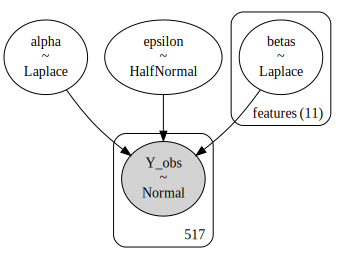

In [21]:
pm.model_to_graphviz(model_lasso)

In [22]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,10.543,1.547,7.694,13.384,0.033,0.024,2233.0,1249.0,1.0
betas[month],0.704,1.090,-0.959,2.979,0.027,0.027,1815.0,984.0,1.0
betas[day],1.194,1.167,-0.795,3.381,0.032,0.025,1449.0,1347.0,1.0
betas[FFMC],0.121,0.924,-1.521,1.985,0.022,0.022,1872.0,1282.0,1.0
betas[DMC],1.516,1.404,-0.837,4.110,0.038,0.030,1475.0,1268.0,1.0
betas[DC],0.141,1.056,-1.603,2.422,0.029,0.026,1409.0,1122.0,1.0
betas[ISI],-0.604,1.074,-2.780,1.237,0.027,0.028,1860.0,1170.0,1.0
betas[temp],2.554,1.699,-0.371,5.561,0.051,0.037,1149.0,1247.0,1.0
betas[RH],-1.638,1.396,-4.271,0.784,0.039,0.030,1410.0,1227.0,1.0
betas[wind],0.650,1.005,-1.024,2.643,0.025,0.024,1825.0,1080.0,1.0


array([<Axes: xlabel='Y_obs'>], dtype=object)

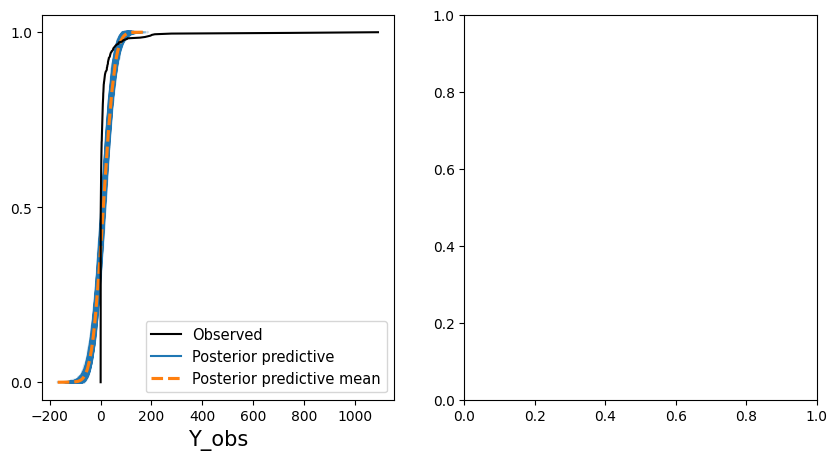

In [23]:
with model_lasso:
  trace_pos_lasso = pm.sample_posterior_predictive(trace_lasso)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_pos_lasso, group='posterior', kind='cumulative', ax=axes[0])

In [24]:
clusters = X_f['cluster'].values.astype(int) # convert the pandas Series to a numpy array of integers

with pm.Model(coords=coords) as model_hierarc:
  alpha = pm.Normal('alpha', mu=0, sigma=10, shape=5)
  betas = pm.Normal('betas', dims='features', mu=0, sigma=10)
  sigma = pm.HalfNormal('sigma', sigma=10)

  mu = alpha[clusters] + tt.dot(X_f, betas)

  Y_obs = pm.Normal('Y_obs', mu, sigma, observed=y)
  trace_hierarc = pm.sample()

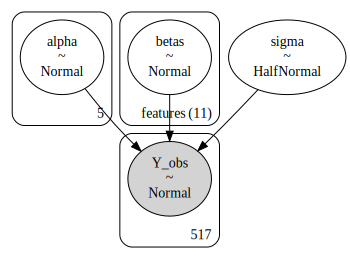

In [25]:
pm.model_to_graphviz(model_hierarc)

In [26]:
pm.summary(trace_hierarc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],10.741,3.009,5.097,16.210,0.054,0.039,3084.0,1667.0,1.0
alpha[1],4.683,6.724,-7.660,17.402,0.153,0.130,1928.0,1454.0,1.0
alpha[2],-0.219,10.139,-19.720,18.057,0.179,0.244,3221.0,1478.0,1.0
alpha[3],0.012,9.942,-19.977,17.257,0.197,0.218,2560.0,1439.0,1.0
alpha[4],15.453,7.082,2.742,29.671,0.169,0.124,1755.0,1490.0,1.0
betas[month],3.880,4.535,-4.977,12.050,0.121,0.088,1397.0,1383.0,1.0
betas[day],2.666,2.665,-2.167,7.701,0.052,0.045,2598.0,1637.0,1.0
betas[FFMC],-0.352,3.161,-5.841,5.768,0.067,0.060,2247.0,1551.0,1.0
betas[DMC],4.629,3.689,-2.359,11.221,0.077,0.055,2282.0,1470.0,1.0
betas[DC],-4.357,5.459,-14.789,5.559,0.147,0.111,1386.0,1325.0,1.0


array([<Axes: xlabel='Y_obs'>], dtype=object)

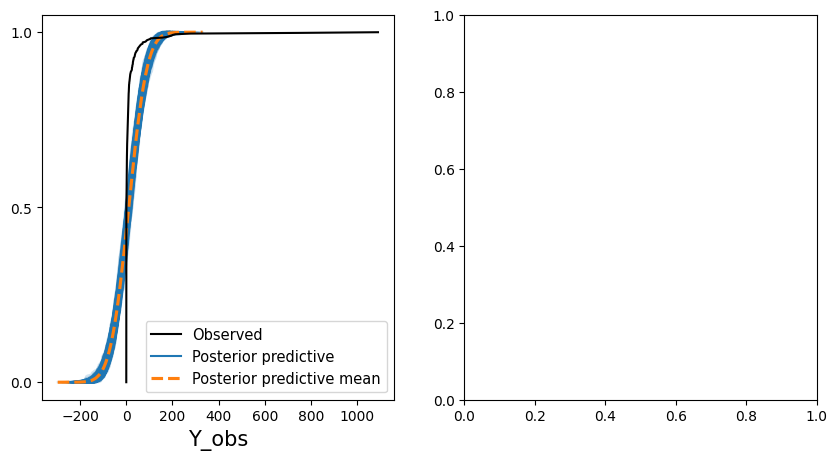

In [27]:
with model_hierarc:
  trace_pos_hierarc = pm.sample_posterior_predictive(trace_hierarc)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_pos_hierarc, group='posterior', kind='cumulative', ax=axes[0])

In [28]:
with model_ridge:
  pm.compute_log_likelihood(trace_ridge)
with model_hierarc:
  pm.compute_log_likelihood(trace_hierarc)
with model_lasso:
  pm.compute_log_likelihood(trace_lasso)

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:789: UserWarning: Estimated

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

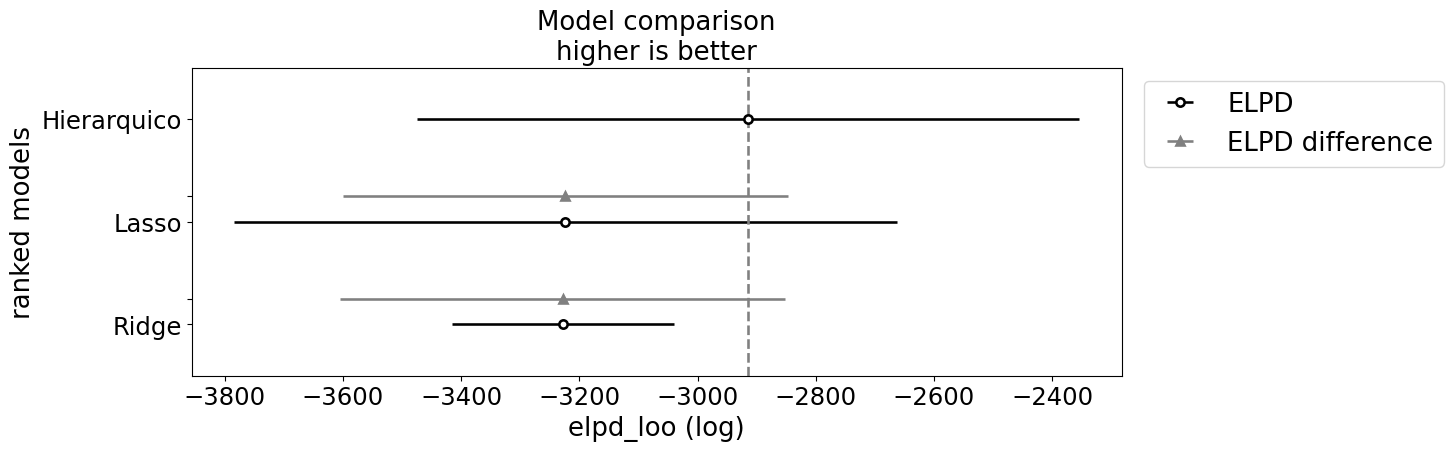

In [29]:
model_compare = az.compare(
    {
        "Ridge": trace_ridge,
        "Lasso": trace_lasso,
        "Hierarquico": trace_hierarc
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)